# Aprendizaje de máquina - Proyecto final

Para este proyecto se eligio el dataset "International football results", disponible en [Kaggle](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017), el cual contiene los siguientes datos:
- date: Fecha del partido
- home_team: nombre del equipo local
- away_team: nombre del equipo visitante
- home_score: goles del equipo local
- away_score: goles del equipo visitante
- tournament: nombre del torneo (amistoso, copa mundial, etc.)
- city: ciudad donde se jugó el partido
- country: país donde se jugó el partido
- neutral: indica si el partido se jugó en un campo neutral

Como **objetivo** se plantea predecir el resultado de los partidos (win, draw, lose).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import log_loss, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

##### 1) EDA: Comprensión inicial del dataset, estadísticas descriptivas, identificación de variables, visualizaciones para entender distribuciones, correlaciones y posibles problemas como valores nulos o atípico.

In [2]:
results = pd.read_csv("./archive/results.csv")
results["date"] = pd.to_datetime(results["date"])

In [3]:
print("Dimensiones del dataset: ", results.shape)
results.head()

Dimensiones del dataset:  (48532, 9)


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


Vemos si el dataset contiene valores nulos y duplicados:

In [4]:
print("Valores nulos:\n", results.isna().sum())
print("\nValores duplicados: ", results.duplicated().sum())

Valores nulos:
 date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

Valores duplicados:  0


Como el dataset original no tiene la variable a predecir, se procede a crearla junto a otras variables que pueden ser útiles para el modelo

In [5]:
results["year"] = results["date"].dt.year
results["month"] = results["date"].dt.month
results["dayofweek"] = results["date"].dt.dayofweek
results["is_weekend"] = results["dayofweek"].apply(lambda x: 1 if x >= 5 else 0)

results["goal_diff"] = abs(results["home_score"] - results["away_score"])
results["total_score"] = results["home_score"] + results["away_score"]

results["result"] = results.apply(
    lambda row: "win" if row["home_score"] > row["away_score"] 
        else ("lose" if row["home_score"] < row["away_score"] else "draw"),
    axis=1)

results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,dayofweek,is_weekend,goal_diff,total_score,result
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,1872,11,5,1,0,0,draw
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,1873,3,5,1,2,6,win
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1874,3,5,1,1,3,win
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,1875,3,5,1,0,4,draw
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1876,3,5,1,3,3,win


In [6]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48532 entries, 0 to 48531
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         48532 non-null  datetime64[ns]
 1   home_team    48532 non-null  object        
 2   away_team    48532 non-null  object        
 3   home_score   48532 non-null  int64         
 4   away_score   48532 non-null  int64         
 5   tournament   48532 non-null  object        
 6   city         48532 non-null  object        
 7   country      48532 non-null  object        
 8   neutral      48532 non-null  bool          
 9   year         48532 non-null  int32         
 10  month        48532 non-null  int32         
 11  dayofweek    48532 non-null  int32         
 12  is_weekend   48532 non-null  int64         
 13  goal_diff    48532 non-null  int64         
 14  total_score  48532 non-null  int64         
 15  result       48532 non-null  object        
dtypes: b

In [7]:
results.describe()

,date,home_score,away_score,year,month,dayofweek,is_weekend,goal_diff,total_score
count,48532,48532.000000,48532.000000,48532.000000,48532.000000,48532.000000,48532.000000,48532.000000,48532.000000
mean,1993-10-17 04:11:45.579823488,1.758180,1.181550,1993.265557,6.883664,3.457018,0.395945,1.716208,2.939730
min,1872-11-30 00:00:00,0.000000,0.000000,1872.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1980-02-27 00:00:00,1.000000,0.000000,1980.000000,4.000000,2.000000,0.000000,1.000000,1.000000
50%,2000-03-15 00:00:00,1.000000,1.000000,2000.000000,7.000000,3.000000,0.000000,1.000000,3.000000
75%,2012-11-07 06:00:00,2.000000,2.000000,2012.000000,10.000000,5.000000,1.000000,2.000000,4.000000
max,2025-09-09 00:00:00,31.000000,21.000000,2025.000000,12.000000,6.000000,1.000000,31.000000,31.000000
std,NaN,1.773101,1.400946,25.301688,3.228533,1.981937,0.489058,1.791796,2.095142


Visualizaciones de variables numéricas

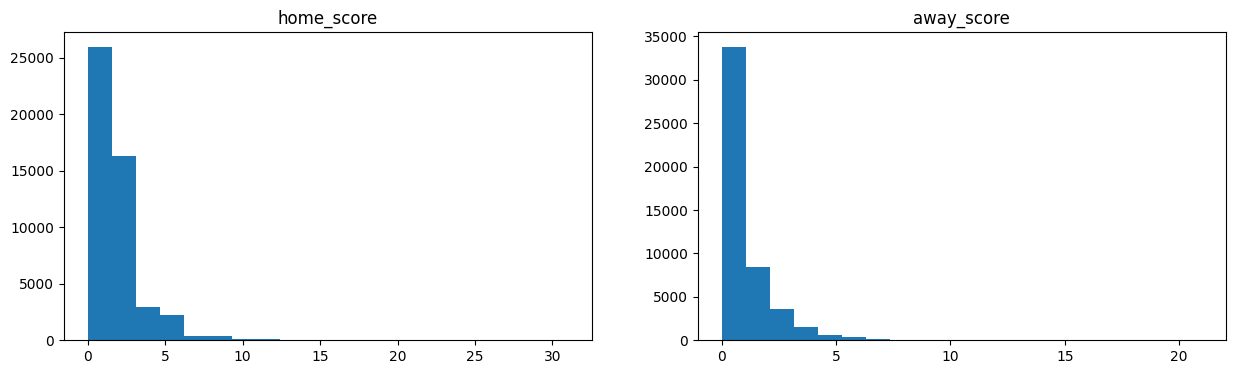

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].hist(results['home_score'], bins=20)
ax[0].set_title('home_score')
ax[1].hist(results['away_score'], bins=20)
ax[1].set_title('away_score')

plt.show()

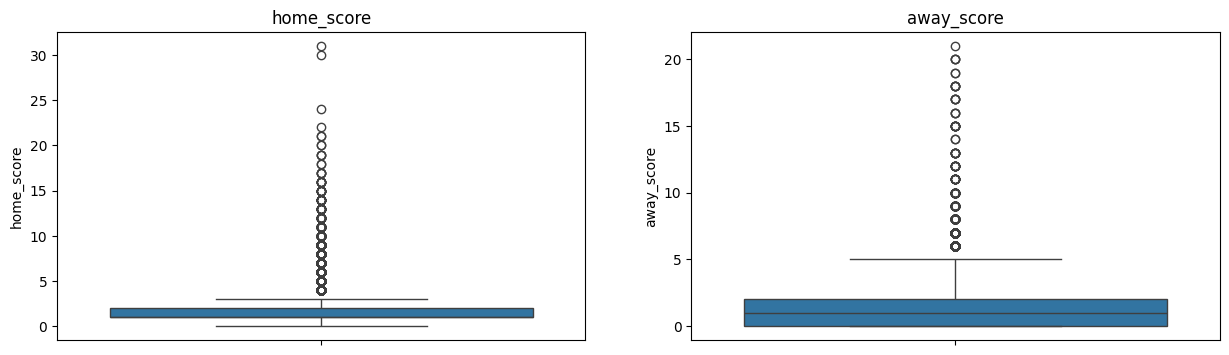

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

sns.boxplot(data=results, y="home_score", ax=ax[0])
ax[0].set_title('home_score')
sns.boxplot(data=results, y="away_score", ax=ax[1])
ax[1].set_title('away_score')

plt.show()

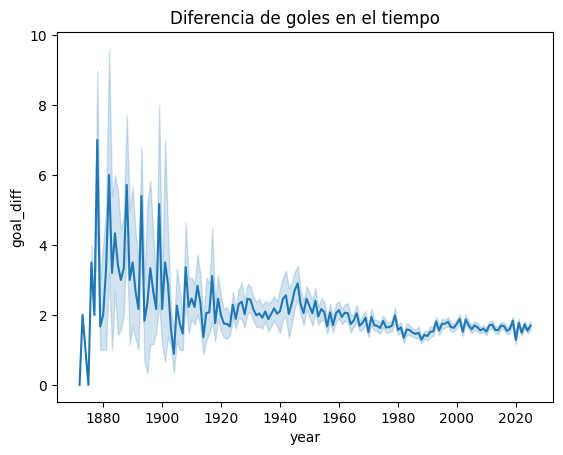

In [10]:
sns.lineplot(data=results, x="year", y="goal_diff")
plt.title("Diferencia de goles en el tiempo")
plt.show()

Vemos que la cantidad de goles se fuerón estabilizando con el tiempo, lo cual es un indicio de que el nivel de los equipos se fue igualando.

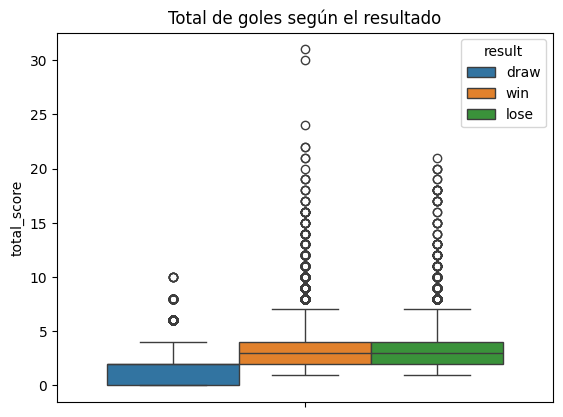

In [11]:
sns.boxplot(data=results, y="total_score", hue="result")
plt.title("Total de goles según el resultado")
plt.show()

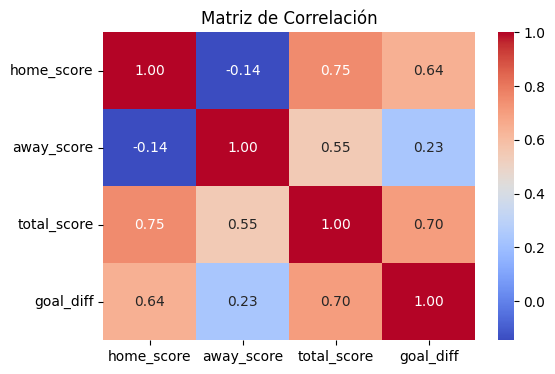

In [12]:
corr = results[["home_score", "away_score", "total_score", "goal_diff"]].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Visualización de variables categoricas

In [13]:
results["home_team"] = results["home_team"].astype('category')
results["away_team"] = results["away_team"].astype('category')
results["tournament"] = results["tournament"].astype('category')
results["city"] = results["city"].astype('category')
results["country"] = results["country"].astype('category')
results["result"] = results["result"].astype('category')

In [14]:
results.describe(include='category')

,home_team,away_team,tournament,city,country,result
count,48532,48532,48532,48532,48532,48532
unique,325,318,188,2115,268,3
top,Brazil,Uruguay,Friendly,Kuala Lumpur,United States,win
freq,608,578,18116,736,1458,23797


Veamos la distribución del target

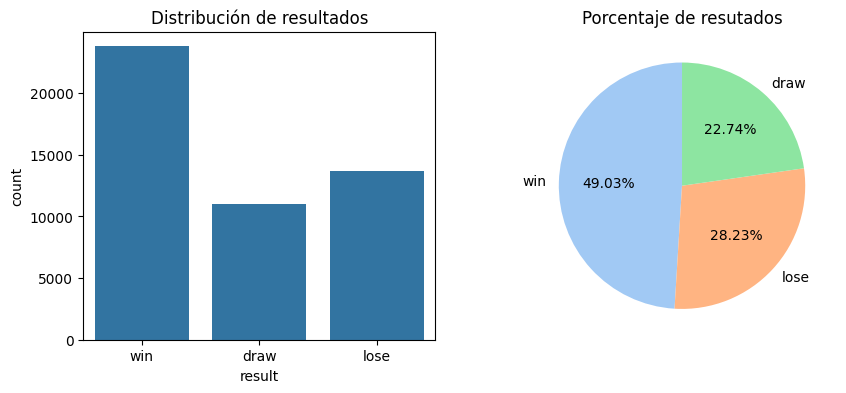

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(data=results, x="result", order=["win","draw","lose"], ax=ax[0])
ax[0].set_title("Distribución de resultados")

results_counts = results['result'].value_counts()
ax[1].pie(results_counts, labels=results_counts.index, autopct='%1.2f%%', startangle=90, colors=sns.color_palette('pastel'))
ax[1].set_title('Porcentaje de resutados')

plt.show()

A partir de los graficos de los resultados, vemos un cierto desbalance en las clases. Esto podría afectar el rendimiento del modelo, haciendo que aprenda mas la clase mayoritaria (win).

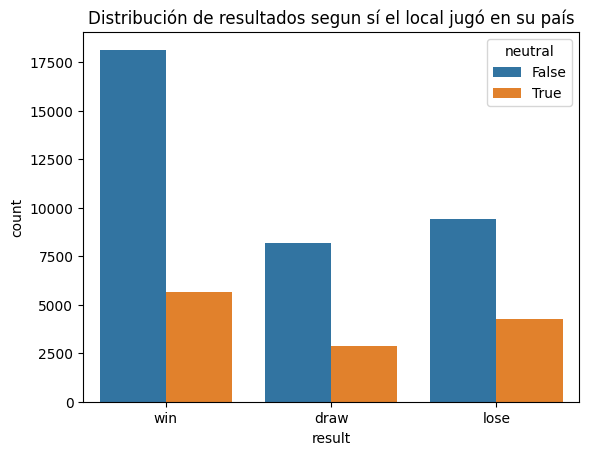

In [16]:
sns.countplot(data=results, x="result", order=["win","draw","lose"], hue="neutral")
plt.title("Distribución de resultados segun sí el local jugó en su país")
plt.show()

Como la cardinalidad de las variables categoricas es muy alta, vamos a graficar aquellos valores que más se destacan:

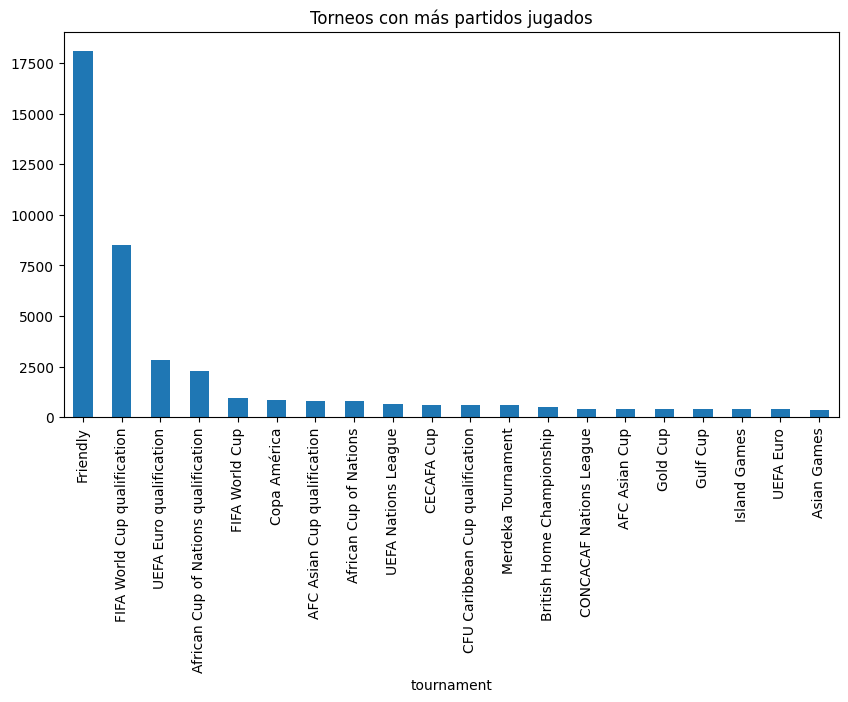

In [17]:
plt.figure(figsize=(10,5))
results["tournament"].value_counts().head(20).plot(kind="bar")
plt.title("Torneos con más partidos jugados")
plt.show()

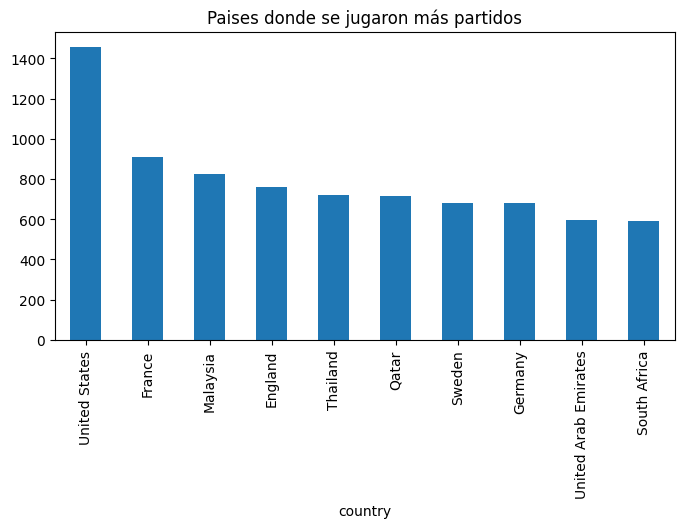

In [18]:
plt.figure(figsize=(8, 4))
results["country"].value_counts().head(10).plot(kind="bar")
plt.title("Paises donde se jugaron más partidos")
plt.show()

De los torneos, se destaca el tipo "amistoso" pero también aprecen torneos pocos conocidos a la par de otros mas conocidos a nivel mundial.

Con los paises sucede algo similar, paises como Malasia o Tailandia tienen una cantidad de partidos importantes.

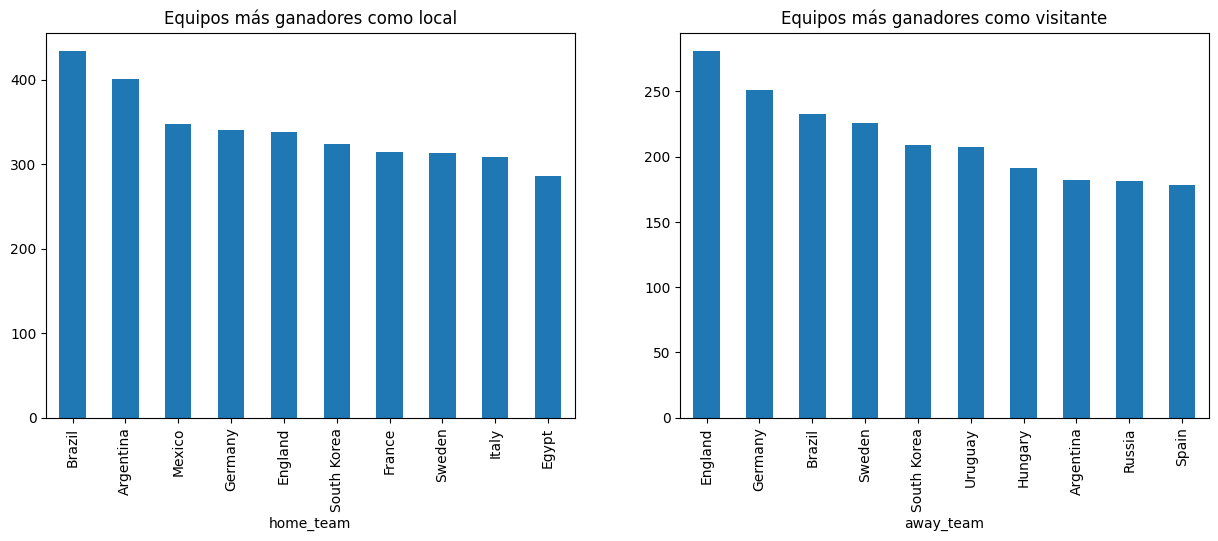

In [19]:
home_winners = results[results["result"] == "win"]
away_winners = results[results["result"] == "lose"]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

home_winners["home_team"].value_counts().head(10).plot(kind="bar", ax=ax[0])
ax[0].set_title("Equipos más ganadores como local")
away_winners["away_team"].value_counts().head(10).plot(kind="bar", ax=ax[1])
ax[1].set_title("Equipos más ganadores como visitante")
plt.show()

 ##### 2) Preprocesamiento y Preparación de Datos: Descripción de las transformaciones aplicadas a los datos para prepararlos para el modelado. Esto incluye, pero no se limita a: limpieza de datos, imputación de valores faltantes, codificación de variables categóricas, escalado de características, etc.

Antes que nada se eliminan los partidos amistosos del dataset, ya que pueden introducir ruido en el modelo. Estos partidos no se juegan con la misma intensidad que los partidos oficiales (suele haber muchos cambios en los equipos, menor motivación, se juega entre equipos de distinto nivel técnico, etc).

**¿Tambien deberiamos considerar solo los torneos mas importantes o mas conocidos?**

In [20]:
# No por ahora, dado que esto filtraría mucho el dataset.
# results_filtered = results[results["tournament"] != "Friendly"].reset_index(drop=True)

results_filtered = results.copy()



Como el objetivo es predecir el resultado del partido, no podemos usar los datos actuales ya que estos son posteriores al partido. Por lo tanto, se crean nuevas variables que representen el rendimiento de los equipos en los últimos partidos jugados, y de esta forma evitamos el *data leakage*. Por ejemplo:
- Tasa de partidos ganados en los últimos N partidos
- Promedio de goles a favor y en contra en los últimos N partidos

In [21]:
window_size = 10  # cantidad de partidos a considerar

# Calcular winrate del equipo local
results_filtered["home_n_winrate"] = (
    results_filtered.groupby("home_team")["result"]
      .apply(lambda x: x.shift().eq("win").rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

# Calcular winrate del equipo visitante
results_filtered['away_n_winrate'] = (
    results_filtered.groupby('away_team')['result']
      .apply(lambda x: x.shift().eq("lose").rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)


# Promedio de goles a favor
results_filtered['home_n_avg_gf'] = (
    results_filtered.groupby('home_team')['home_score']
      .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

results_filtered['away_n_avg_gf'] = (
    results_filtered.groupby('away_team')['away_score']
      .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

# Promedio de goles en contra
results_filtered['home_n_avg_ga'] = (
    results_filtered.groupby('home_team')['away_score']
      .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

results_filtered['away_n_avg_ga'] = (
    results_filtered.groupby('away_team')['home_score']
      .apply(lambda x: x.shift().rolling(window_size, min_periods=1).mean())
      .reset_index(level=0, drop=True)
)

/var/folders/ff/89s4xv1x5210pv23kt90w28c0000gn/T/ipykernel_54432/2586177956.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results_filtered.groupby("home_team")["result"]
/var/folders/ff/89s4xv1x5210pv23kt90w28c0000gn/T/ipykernel_54432/2586177956.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results_filtered.groupby('away_team')['result']
/var/folders/ff/89s4xv1x5210pv23kt90w28c0000gn/T/ipykernel_54432/2586177956.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=Tru

In [22]:
results_filtered.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,...,is_weekend,goal_diff,total_score,result,home_n_winrate,away_n_winrate,home_n_avg_gf,away_n_avg_gf,home_n_avg_ga,away_n_avg_ga
48527,2025-09-09,Bosnia and Herzegovina,Austria,1,2,FIFA World Cup qualification,Zenica,Bosnia and Herzegovina,False,2025,...,0,1,3,lose,0.3,0.6,0.9,1.9,1.8,0.9
48528,2025-09-09,Cyprus,Romania,2,2,FIFA World Cup qualification,Nicosia,Cyprus,False,2025,...,0,0,4,draw,0.3,0.5,0.7,1.9,2.0,1.1
48529,2025-09-09,Norway,Moldova,11,1,FIFA World Cup qualification,Oslo,Norway,False,2025,...,0,10,12,win,0.7,0.2,2.1,0.6,0.5,1.4
48530,2025-09-09,Albania,Latvia,1,0,FIFA World Cup qualification,Tirana,Albania,False,2025,...,0,1,1,win,0.3,0.1,1.0,0.5,0.8,2.3
48531,2025-09-09,Serbia,England,0,5,FIFA World Cup qualification,Belgrade,Serbia,False,2025,...,0,5,5,lose,0.5,0.7,1.6,1.8,0.8,0.7


In [23]:
results_filtered.isna().sum()[results_filtered.isna().sum() > 0]

home_n_avg_gf    325
away_n_avg_gf    318
home_n_avg_ga    325
away_n_avg_ga    318
dtype: int64

En base al procesamiento realizado, aparecen valores nulos en el promedio de goles a favor y en contra. Se decide imputar estos valores con 1.

In [24]:
features_nulls = [
    'home_n_avg_gf', 'away_n_avg_gf',
    'home_n_avg_ga', 'away_n_avg_ga',
]

results_filtered[features_nulls] = results_filtered[features_nulls].fillna(1.0)

Codificamos las variables categoricas:
- result se codifica con LabelEncoder por ser la variable a predecir
- home_team, away_team, tournament se codifican con TargetEncoder por tener una cardinalidad alta (**posible leakage?**)

In [25]:
result_encoder = LabelEncoder()
results_filtered["result_enc"] = result_encoder.fit_transform(results_filtered["result"])
print("Clases del resultado: ", result_encoder.classes_)

tournament_encoder = TargetEncoder()
results_filtered["tournament_enc"] = tournament_encoder.fit_transform(results_filtered["tournament"], results_filtered["result_enc"])

home_team_encoder = TargetEncoder()
results_filtered["home_team_enc"] = home_team_encoder.fit_transform(results_filtered["home_team"], results_filtered["result_enc"])

away_team_encoder = TargetEncoder()
results_filtered["away_team_enc"] = away_team_encoder.fit_transform(results_filtered["away_team"], results_filtered["result_enc"])

results_filtered["neutral"] = results_filtered["neutral"].astype(int)

Clases del resultado:  ['draw' 'lose' 'win']


##### 3) Modelado: Construcción y entrenamiento de los modelos de aprendizaje automático.

Como el resultado de un partido puede estar influenciado por resultados anteriores (el rendimiento previo que tuvo el equipo), se decide tratar al dataset como una serie temporal. Por lo tanto, se divide en conjunto de entrenamiento y prueba según una fecha determinada.

In [26]:
train = results_filtered[results_filtered["date"] < "2018-01-01"]
test = results_filtered[results_filtered["date"] >= "2018-01-01"]
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (41257, 26)
Test shape: (7275, 26)


In [3]:
# Definimos las features que usaremos para el modelo:
features = [
    # 'home_n_winrate', 'away_n_winrate',
    # 'home_n_avg_gf', 'away_n_avg_gf',
    # 'home_n_avg_ga', 'away_n_avg_ga',
    'neutral', 'tournament_enc',
    'home_team_enc', 'away_team_enc',
    #'month', 
    'is_weekend'
]

target = "result_enc"

X_train, y_train = train[features], train[target]

# Balancear las clases con SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Balancear las clases con RandomUnderSampler 
#undersample = RandomUnderSampler(random_state=42)
#X_train, y_train = undersample.fit_resample(X_train, y_train)

X_test, y_test = test[features], test[target]

NameError: name 'train' is not defined

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(x=y_train, order=[0, 1, 2], ax=ax[0])
ax[0].set_title("Distribución de resultados")

results_counts = y_train.value_counts()
ax[1].pie(results_counts, labels=results_counts.index, autopct='%1.2f%%', startangle=90, colors=sns.color_palette('pastel'))
ax[1].set_title('Porcentaje de resutados')

plt.show()

NameError: name 'plt' is not defined

Escalamos las variables para que todas esten en la misma escala.

In [29]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [30]:
def print_classification_results(y_test, y_pred, model_name):
    target_names = result_encoder.classes_
    print(f"\nResultados para {model_name}:")

    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))

    print("\nClassification Report:\n", 
          classification_report(y_test, y_pred, 
                              target_names=target_names,
                              zero_division=0))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="cool", cbar=True,
                xticklabels=target_names,
                yticklabels=target_names)
    plt.tight_layout()
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()

Para modelar el problema, se van a utilizar diferentes algoritmos de clasificación


Resultados para Regresión Logística:

Accuracy: 0.5206872852233677
F1-score (macro): 0.46665331307352886

Classification Report:
               precision    recall  f1-score   support

        draw       0.29      0.22      0.25      1677
        lose       0.46      0.56      0.50      2120
         win       0.65      0.64      0.65      3478

    accuracy                           0.52      7275
   macro avg       0.47      0.47      0.47      7275
weighted avg       0.51      0.52      0.51      7275



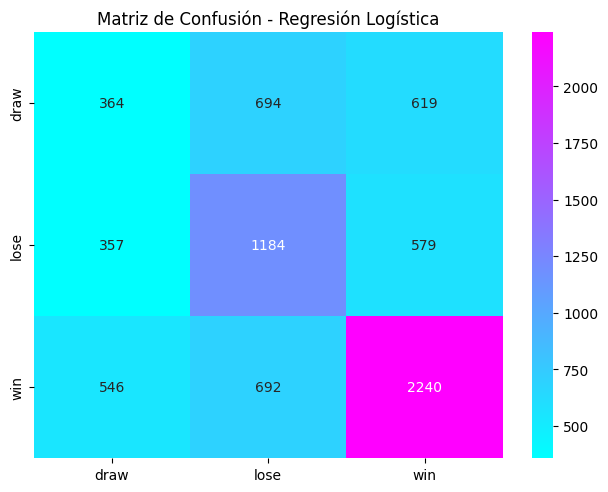

In [31]:
# Modelo baseline: regresión logística multiclase
logreg = LogisticRegression(max_iter=1000, class_weight="balanced")
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print_classification_results(y_test, y_pred, "Regresión Logística")


Resultados para KNN:

Accuracy: 0.471340206185567
F1-score (macro): 0.4477944512080125

Classification Report:
               precision    recall  f1-score   support

        draw       0.26      0.35      0.30      1677
        lose       0.44      0.46      0.45      2120
         win       0.66      0.53      0.59      3478

    accuracy                           0.47      7275
   macro avg       0.45      0.45      0.45      7275
weighted avg       0.50      0.47      0.48      7275



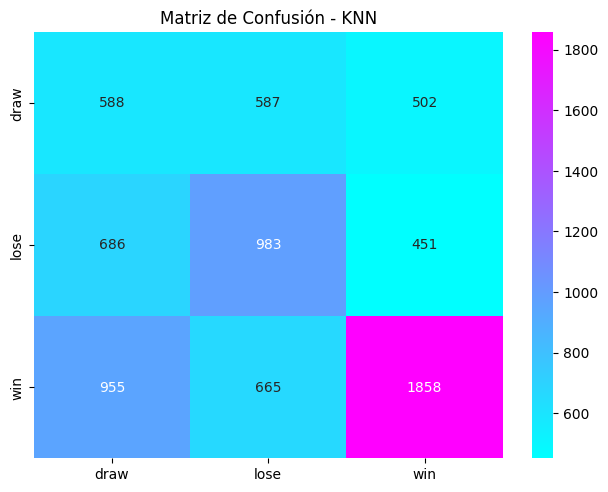

In [32]:
# KNN
knn = KNeighborsClassifier(n_neighbors=21, metric="minkowski", p=2)
knn.fit(X_train, y_train)

y_pred  = knn.predict(X_test)

print_classification_results(y_test, y_pred, "KNN")


Resultados para SVC:

Accuracy: 0.509553264604811
F1-score (macro): 0.47112653364343204

Classification Report:
               precision    recall  f1-score   support

        draw       0.28      0.29      0.29      1677
        lose       0.47      0.52      0.49      2120
         win       0.67      0.61      0.64      3478

    accuracy                           0.51      7275
   macro avg       0.47      0.47      0.47      7275
weighted avg       0.52      0.51      0.51      7275



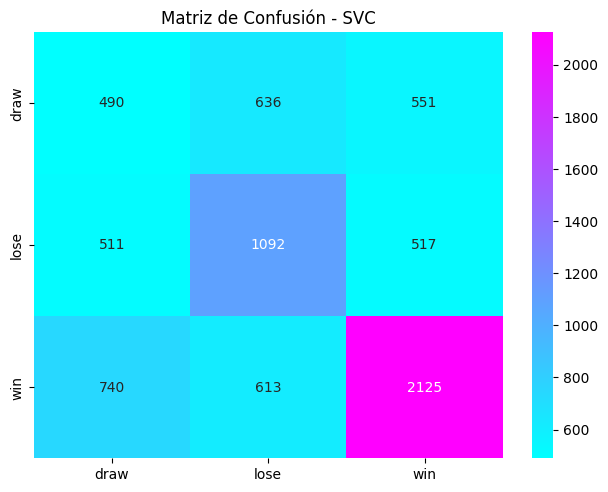

In [33]:
svc = SVC(C=5, kernel="rbf", decision_function_shape='ovo', probability=True)
svc.fit(X_train, y_train)

y_pred  = svc.predict(X_test)

print_classification_results(y_test, y_pred, "SVC")


Resultados para Árbol de Decisión:

Accuracy: 0.5068041237113402
F1-score (macro): 0.45652083595200804

Classification Report:
               precision    recall  f1-score   support

        draw       0.26      0.23      0.24      1677
        lose       0.46      0.52      0.49      2120
         win       0.64      0.64      0.64      3478

    accuracy                           0.51      7275
   macro avg       0.45      0.46      0.46      7275
weighted avg       0.50      0.51      0.50      7275



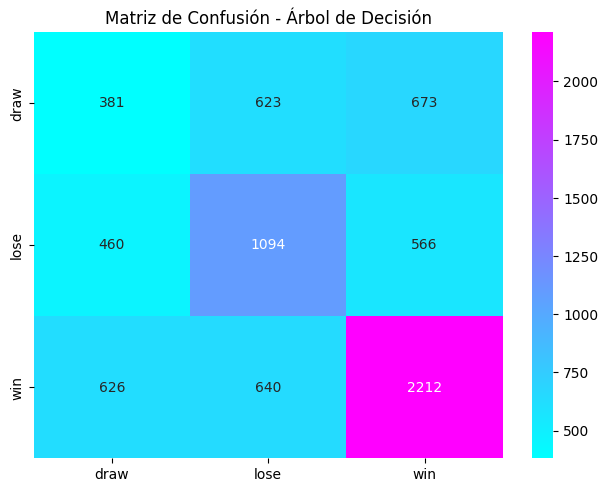

In [34]:
# Arbol de decisión
dtc = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                        max_depth=10, min_samples_split=8, min_samples_leaf=5,
                                        class_weight='balanced',
                                        random_state=42)
dtc.fit(X_train, y_train)

y_pred  = dtc.predict(X_test)

print_classification_results(y_test, y_pred, "Árbol de Decisión")


Resultados para Random Forest:

Accuracy: 0.5147766323024054
F1-score (macro): 0.4713672403717255

Classification Report:
               precision    recall  f1-score   support

        draw       0.28      0.27      0.27      1677
        lose       0.48      0.53      0.50      2120
         win       0.65      0.63      0.64      3478

    accuracy                           0.51      7275
   macro avg       0.47      0.47      0.47      7275
weighted avg       0.51      0.51      0.51      7275



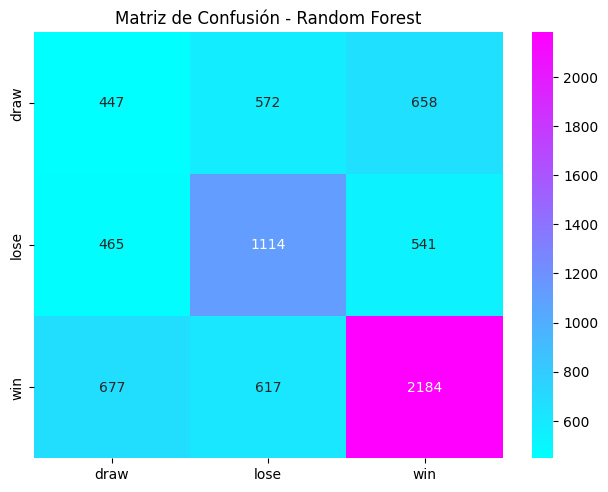

In [35]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=15, 
                             min_samples_split=8, min_samples_leaf=3, 
                             class_weight='balanced', random_state=42)
rfc.fit(X_train, y_train)

y_pred  = rfc.predict(X_test)

print_classification_results(y_test, y_pred, "Random Forest")

Accuracy: 0.5086942257217848
Log Loss: 0.9779584838387193

Resultados para XGBoost:

Accuracy: 0.5086942257217848
F1-score (macro): 0.5045092866868527

Classification Report:
               precision    recall  f1-score   support

        draw       0.46      0.38      0.41      4032
        lose       0.51      0.53      0.52      4143
         win       0.55      0.62      0.58      4017

    accuracy                           0.51     12192
   macro avg       0.50      0.51      0.50     12192
weighted avg       0.50      0.51      0.50     12192



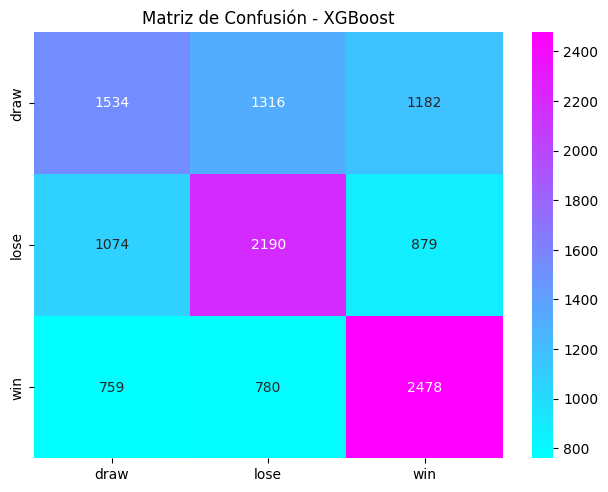

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix

# Features y target (mismo dataset que usamos para la logística)
# X = X_train[[
#     "home_n_winrate", "home_n_avg_gf", "home_n_avg_ga",
#     "away_n_winrate", "away_n_avg_gf", "away_n_avg_ga" 
# ]]
# y = y_train["target_enc"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=True, random_state=42
)

gb_clf = GradientBoostingClassifier(
    n_estimators=300,     # más árboles = mejor performance, hasta cierto punto
    learning_rate=0.05,   # tasa de aprendizaje baja = más estable
    max_depth=3,          # profundidad de cada árbol
    random_state=42
)

# Entrenamiento
gb_clf.fit(X_train, y_train)

# Predicciones
y_pred = gb_clf.predict(X_test)
y_prob = gb_clf.predict_proba(X_test)

# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Log Loss:", log_loss(y_test, y_prob))
#print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le_result.classes_))
print_classification_results(y_test, y_pred, "XGBoost")
#print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

##### 4) Evaluación de Resultados: Análisis cuantitativo y cualitativo del rendimiento de los modelos utilizando métricas apropiadas. Se deben interpretar los resultados en el contexto del problema original.

En el contexto de este problema, queremos que el modelo prediga las clases del resultado por igual. Por lo que nos vamos a enfocar la métrica de accuracy, pero como existe un desbalance en las clases, también se va a considerar la métrica de F1-score global.

In [ ]:
# Comparacion de resultados

---
Para discutir

- Los graficos les parecen adecuados? o agreagarian/quitarian alguno?
Sí.

- ¿Qué otras variables podrían ser útiles para mejorar el modelo? Falta adaptar las metricas que usó Carlos
Agregar métricas para empate.   

- Eliminar los partidos amistosos les parece adecuado? Deberiamos considerar solo los torneos mas importantes?
Yo lo dejaría pero podemos probar.

- La codificación de las variables categoricas les parece adecuada? Use TargetEncoder por simplcidad.
Sí, otra opción es un Ordinal encoding (ranking fifa)

- El split temporal les parece adecuado? Parece tener sentido
No, creo que estamos entrando en otro mundo, pero es solo una opibión XD.
Podríamos usar los datos desde cierta fecha.

- Faltaria agregar los algoritmos XGBoost/LightGBM y Redes Neuronales 
De acuerdo.

- Falta agregar ensamble

- Y si convertimos el problema a uno de clasificación binaria (win vs no win)? Podria simplificar el problema y mejorar los resultados
Ojo.